## Coulomb Collisions
2D simulations of particle collisions
***

We will be using the 2D version of **ZPIC**. With this particle in cell code we are required to initialize a full plasma instead of a single particle. However, we may still track single particles and eliminate collective effects by decreasing the plasma density.




#### About the phenomenon

When the plasma is composed of ions and electrons alone, all collisions are Coulomb collisions between charged particles. 

Here we explore this interaction by analysing the Rutherford cross section. Rutherford scattering is the elastic scattering of charged particles by the Coulomb interaction.
The equations of motion describing two particles interacting under a central force can be decoupled into the center of mass and the motion of the particles relative to one another. For the case of light alpha particles scattering off heavy nuclei, as in the experiment performed by Rutherford, the reduced mass is essentially the mass of the alpha particle and the nucleus off of which it scatters is essentially stationary in the lab frame.

The deflection angle depends on the impact parameter (the transversal distance between teh incoming particle and the satationary one).

For a uniform distribution of incoming particles the differential cross section of the interaction will be given by

${\frac {d\sigma }{d\Omega }}=\left({\frac {Z_{1}Z_{2}\alpha (\hbar c)}{4E_{\mathrm {K} }\sin ^{2}{\frac {\Theta }{2}}}}\right)^{2}$

#### About the simulation

In order to simulate this phenomenon, we make an electron species collide with the field from a fixed charge.

The fixed charge is emulated by an external coulomb field.

The differential cross section can be computed by finding the deflection angle at the end of the simulation given by $\theta=\arctan{u_y/u_x}$ for each particle.

In [28]:
# get ZPIC 2D
import em2d
import numpy as np

# Simulation time
tmax = 22.8

# Number of cells
nx  = [256+64,256+128+64]

# Simulation box size
box = [10,14]

# Time step
def courant(dx,dy):
    return 1/np.sqrt(1/dx**2+1/dy**2)
dt = 0.999*courant(box[0]/nx[0],box[1]/nx[1])

# Particles per cell
ppc = [2,4]

def custom_nx(x):
    return 1 if (x>0.1 and x<0.28) else 0.0

def custom_ny(x):
    return 1 if (x>1 and  x<13  ) else  0.0

dens = em2d.Density( type = "custom", custom_x = custom_nx,custom_y=custom_ny )
dens.n=1e-8
#create the species give it a small velocity to kick of the motion
electrons = em2d.Species( "electrons", -1, ppc,
                           density = dens,ufl=[0.1,0,0],n_sort=0)

sim = em2d.Simulation( nx, box, dt, species = electrons )

# Coulomb field for the fixed charge
radi=(2*np.sqrt(2)*box[0]/nx[0])**2
def col_fld(ix,dx,iy,dy):
    x0 =6
    y0 = 7.015625
    
    x = (ix+0.5)*dx       - x0;
    y = (iy)*dy - y0;

    r2 = x*x+y*y
    if r2<radi:
        r2=radi
    ex = x/r2*1.5e-3;

    x = (ix)*dx - x0;
    y = (iy+0.5)*dy       - y0;
    r2 = x*x+y*y 
    if r2<radi:
        r2=radi
    ey = y/r2*1.5e-3;
    return [-ex,-ey,0] 

ext = em2d.ExternalField(E_type = 'custom', E_custom = col_fld )

sim.emf.set_ext_fld( ext )


This is the the scattering electric field 

(5.0, 9.0)

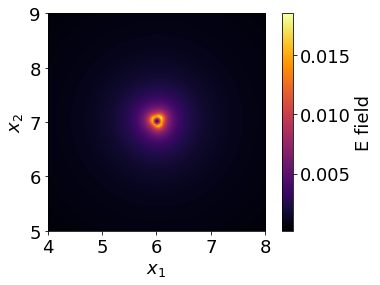

In [41]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.imshow( np.sqrt(sim.emf.Ex_part**2+sim.emf.Ey_part**2), interpolation = 'bilinear', origin = 'lower',
          extent = ( 0,sim.box[0],0,sim.box[1] ),
          aspect = 'equal', cmap = 'inferno' )
plt.colorbar().set_label('E field')

plt.xlim(4,8)
plt.ylim(5,9)

Now running the simulation

In [29]:
#arays to store the particles trajectories
ele_part_rep =[]

while sim.t < 32*np.pi:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    ele_part_rep.append(electrons.particles[:].copy())
    sim.iter()

### Checking the results

Here you can check the trajectories of a randomly selected set of particles

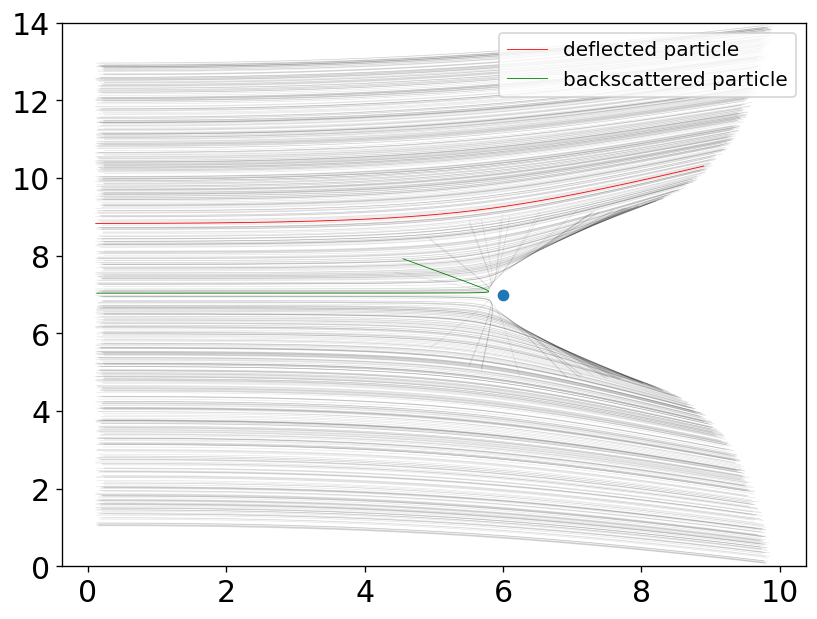

In [30]:
import random
import matplotlib.pyplot as plt
import matplotlib as mpl

#select a random subset of the particles in the simulation
p_idx=random.sample(range(len(electrons.particles)),len(electrons.particles)//20)
a=np.transpose(ele_part_rep)

#Set up the plot
fig=plt.figure(figsize=(8, 6), dpi=120)
plt.rcParams.update({'font.size': 18})
ax=plt.gca()

#plot trajectories
for particle  in a[p_idx]:
    e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in particle]
    e_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in particle]
    ax.plot(e_posx_t,e_posy_t,c="k",alpha=0.1,lw=0.4)

    
e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in a[1000]]
e_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in a[1000]]
ax.plot(e_posx_t,e_posy_t,c="r",lw=0.5,label="deflected particle")

e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in a[2300]]
e_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in a[2300]]
ax.plot(e_posx_t,e_posy_t,c="g",lw=0.5,label="backscattered particle")

ax.scatter(6,7)
ax.set_ylim([0,14])
ax.legend(fontsize=12,loc=1)
plt.show()

Below you'll find the histogram of the final deflection angles together with the theopretical Rutherford cross section

Why are there no  particles with deflection angles near 0?

(0.0, 400.0)

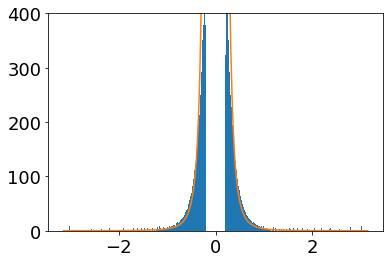

In [42]:
plt.hist( np.arctan2(electrons.particles["uy"],electrons.particles["ux"]), bins = 512, label ='particles' )
angles=np.linspace(-np.pi,np.pi,512)
plt.plot(angles,2e-1/np.sin(angles/2)**4)
#plt.yscale('log')
plt.ylim([0,400])